# MusicLab Copenhagen Audience motion measurements, preparations

After combining MusicLab app accelerometer measurements:

and aligning measurements with the imbedded synchronisation taps in mobile phone measurements (MusicLab) and AX3 sensors: 

This notebook characterises the initial measurements patterns of gaps, the scaling of the AX3 sensor values, and the downsampling of all measurements into an aligned set of instantaneous jerk measurements. 


In [1]:
import sys
import os
import time

import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.cm as cm
import pingouin as pg

In [2]:
# import functions from definition files in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport am
%aimport frf

In [3]:
%reload_ext autoreload

# Data preparation 
Aligning cellphone accelerometer measurements collected via MusicLab App and AX3 measurements from audience participant was performed in a different repository. This process depended on the detection of taps by participants on their devices to the synchronisation cues played before each half of the concert. See Notebook below for a summary of that work to align accelerometer measurements: 
https://github.com/finn42/MusicLabCopenhegan_MotionAlignment/blob/main/Alignment_Describe.ipynb

These aligned accelerometer measurments were released publically as part of the MusicLab Copenhagen repository (https://osf.io/v9wa4/). This analysis uses the fullowing published datasets from this study:

  1. Aligned accelerometer measurements from each audience member: https://osf.io/9qeg6/
  2. Participants' survey responses: https://osf.io/89s5w/ 
  3. Anonimised seating information for in hall participants: https://osf.io/8t4rz/ ./Participants/Near_Participants_Hall.csv (https://osf.io/c5zgf)
  4. Concert event timing information:  https://osf.io/8t4rz/ ./Timing/Events_Main.csv

In [4]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [5]:
internal_Part = general_loc + 'Participants_internal/'

In [6]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)


In [7]:
concert_times = pd.read_csv(public_time +'Events_Main_extra_Tags.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [14]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
part_det_columns = ['Participant_Code','Attendance', 'Motion_Quality', 'Seat_Zone','Watch_Alone']
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),part_det_columns] # A in person hall participants, B remote participants 
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
print(len(aligned_Part_Codes))
alignedParts.iloc[:5,:]

115


,Participant_Code,Attendance,Motion_Quality,Seat_Zone,Watch_Alone
0,ADQ001,A,Q,6.0,0.0
1,ADQ002,A,Q,3.0,0.0
2,ADQ003,A,Q,2.0,0.0
3,ADQ004,A,Q,4.0,1.0
4,ADQ005,A,Q,4.0,0.0


One of the unfortunate characteristics of the cellphone measurements is their inconsistent sample rates and frequent gaps. Measurements per device were transmitted in 60 s batches, however there were (for as of yet undetermined reasons) often gaps between batches, sometimes of several seconds. These frequent discontinuities complicate how this data can be treated. Some steps taken were necessary compromises because of these measurement issues. There were also discontinuities from participants turning off the app to answer questions (remote participants only) or during intermission. To handle these gaps with care throughout these analyses, we inserted NaN values in any gaps lasting more than a second before resampling the ACC measurements to get Quantity of Motion measures on common timestamp values.

Lastly there was some data loss from phones lossing power or th app being accidentally or incidentally turned off/closed.

The individual participants accelerometer measurements during the concert experiment were resampled to matching timestamps at 50 Hz

In [19]:
# concert times 50 Hz This is the original sample rate on which the compensation for ax3 sensors were evaluated
ts_ct = np.arange(-1086,9715, 0.02)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
binlist = np.concatenate((np.arange(0,200,20),np.arange(200,1000,200),np.arange(1000,10000, 1000),np.array([50000,1000000])),axis=0)

binlist captures the sizes of gaps surviving after resampling. counting in milliseconds. the lists are different from the two sample raes, initial 50 hz and the later 10 hz. 

The choice of sampling and aligning on 50 Hz was to ensure that most points were interpolated. All sequences would have to be resampled to be put on the same time stamps, but staying with the same rate would allow patches to be imported without resampling against a majority that would be generated with interpolation. By choising a high but offset sample rate, this ensures no stretches of original data with any quirks it might retain. 

The later choice of 10 Hz is a downsampling that reduces the impacts of high frequency noise on the calculations and reduce the computational burden of these analyses. While downsampling is usually performed after lowpass filtering to remove aliasing noise effects, that is not possible here because of uneven sample rates of the original data. This resampling carries some sensor noise as well as movement noise, however, that noise is used in some analyses (spearman correlations), and all measurements retain comparable noise, so the impacts are not distinguishing between devices or participants. 

In [20]:

binlist

array([      0,      20,      40,      60,      80,     100,     120,
           140,     160,     180,     200,     400,     600,     800,
          1000,    2000,    3000,    4000,    5000,    6000,    7000,
          8000,    9000,   50000, 1000000])

In [21]:
samples_df=pd.DataFrame(index = alignedParts['Participant_Code'],columns = ['Sensor','Average Sample rate','Median sample period','Missing Samples','Average Normed ACC','Median Normed Jerk','New Median Jerk']+list(binlist[1:]))
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
bad_gaps = []
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
    print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
        samples_df.loc[part,'Sensor'] = 'Mobile'
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
        samples_df.loc[part,'Sensor'] = 'AX3'
    samples_df.loc[part,'Average Sample period'] = inst_d['device_timestamps'].diff().mean()/1000 #len(inst_d)/((inst_d.time.iloc[-1]-inst_d.time.iloc[0])/1000)
    samples_df.loc[part,'Median sample period'] = inst_d['device_timestamps'].diff().median()/1000
    samples_df.loc[part,'Average Normed ACC'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).median()
    samples_df.loc[part,'Median Normed Jerk'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).diff().abs().median()
    samples_df.loc[part,'UpQ Normed ACC'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).quantile(0.75)
    samples_df.loc[part,'UpQ Normed Jerk'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).diff().abs().quantile(0.75)
    samples_df.loc[part,'95 Normed ACC'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).quantile(0.95)
    samples_df.loc[part,'95 Normed Jerk'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).diff().abs().quantile(0.95)
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
#         aud_df.loc[:,part] = b
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
    hist, edges = np.histogram(inst_d['device_timestamps'].diff(),bins=binlist,density=False)
    samples_df.loc[part,list(binlist[1:])] = hist
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct
samples_df.loc[:,'New Median Jerk'] = aud_df.median()
samples_df.loc[:,'New UpQ Jerk'] = aud_df.quantile(0.75)
samples_df.loc[:,'New 95 Jerk'] = aud_df.quantile(0.95)

ADQ001
ADQ002
ADQ003
ADQ004
ADQ005
ADQ006
ADQ007
ADQ008
ADQ009
ADQ010
ADQ011
ADQ012
ADQ013
ADQ014
ADQ015
ADQ016
ADQ017
ADQ018
ADQ019
ADQ020
ADQ021
ADQ022
ADQ023


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

ADQ024
ADQ025
ADQ026
ADQ027
ADQ028
ADQ029
ADQ030
ADQ031
ADQ032
ADQ033
ADQ034
ADQ035
ADQ036
ADQ037
ADQ038
ADQ039
ADQ040
ADQ041
ADQ042
ADQ043
ADQ044
ADQ045
ADQ046
ADQ047
ADQ048
ADQ049
ADQ050
ADQ051
ADQ052
ADQ053
ADQ054
ADQ055
ADQ056
ADQ057
ADQ058
ADQ059
ADQ060
ADQ061
ADQ062
ADQ063
ADQ064
ADQ065
ADQ066
ADR067
ADR068
ADR069
ADR070
ADR071
AEQ077
AEQ078
AEQ079
AEQ080
AEQ081
AEQ082
AEQ083
AEQ084
AEQ085
AEQ086
AEQ087
AEQ088
AEQ089
AER090
BDQ092
BDQ093
BEQ095
BEQ096
BEQ097
BEQ098
BEQ099
BEQ100
BEQ101
BEQ102
BEQ103
BEQ104
BEQ105
BEQ106
BEQ107
BEQ108
BEQ109
BEQ110
BEQ111
BEQ112
BEQ113
BEQ114
BEQ115
BEQ116
BEQ117
BEQ118
BEQ119
BnQ131
BnQ132
BnQ133
190.17425990104675
190.5790638923645


### analysis of gaps in mobile phone recordings

In [68]:
samples_df.iloc[:5,:]

,Sensor,Average Sample rate,Median sample period,Missing Samples,Average Normed ACC,Median Normed Jerk,New Median Jerk,20,40,60,...,9000,50000,1000000,Average Sample period,UpQ Normed ACC,UpQ Normed Jerk,95 Normed ACC,95 Normed Jerk,New UpQ Jerk,New 95 Jerk
Participant_Code,,,,,,,,,,,,,,,,,,,,,
ADQ001,Mobile,NaN,0.017,NaN,9.861908,0.015808,0.033952,424058,614,12,...,0,0,0,0.023170,9.884882,0.039368,10.009002,0.183908,0.078325,0.357148
ADQ002,Mobile,NaN,0.017,NaN,9.684524,0.04566,0.090139,206705,1651,15,...,0,0,0,0.044421,9.731393,0.086983,9.867624,0.221312,0.136017,0.397436
ADQ003,Mobile,NaN,0.017,NaN,9.9,0.00757,0.068641,446682,4157,1,...,0,0,0,0.020520,9.938813,0.083981,10.031949,0.186195,0.101545,0.335062
ADQ004,Mobile,NaN,0.017,NaN,9.694328,0.017985,0.085714,427093,23547,10,...,0,1,0,0.020542,9.739096,0.092794,9.971961,0.256736,0.126710,0.513089
ADQ005,Mobile,NaN,0.017,NaN,9.793292,0.020406,0.03965,489151,1456,5,...,0,0,0,0.020024,9.820093,0.039702,9.884419,0.109884,0.068729,0.190112


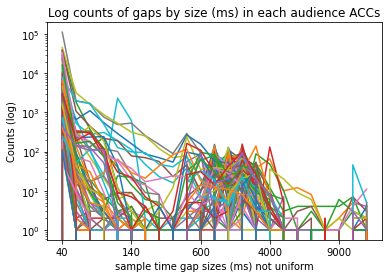

In [59]:
samples_df[binlist[2:]].T.plot(logy=True,legend=False)
plt.title('Log counts of gaps by size (ms) in each audience ACCs')
plt.ylabel('Counts (log)')
plt.xlabel('sample time gap sizes (ms) not uniform')
plt.savefig('Sampling_gaps_distributions.png',dpi = 196)

plt.show()

In [80]:
binlist[3:23]

array([  60,   80,  100,  120,  140,  160,  180,  200,  400,  600,  800,
       1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])

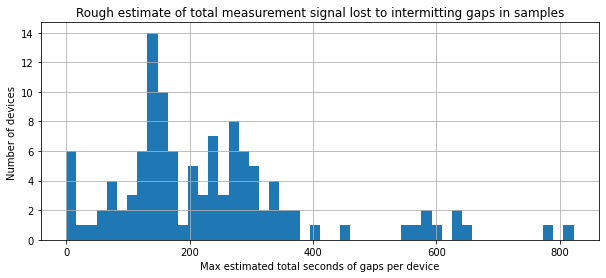

In [81]:
K = samples_df[binlist[1:]].copy()
for c in K: K[c] = K[c]*c # max time lost in gap
(K[binlist[3:23]].sum(axis=1)/1000).hist(bins = 50,figsize = [10,4])
plt.title('Rough estimate of total measurement signal lost to intermitting gaps in samples')
plt.xlabel('Max estimated total seconds of gaps per device')
plt.ylabel('Number of devices ')
plt.savefig('SecondsLost_hist.png',dpi = 196)
plt.show()

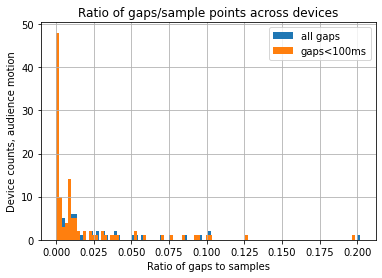

array([ 40,  60,  80, 100])

In [70]:
(samples_df[binlist[2:]].sum(axis=1)/samples_df[binlist[1:]].sum(axis=1)).hist(bins=100,label='all gaps')
(samples_df[binlist[2:6]].sum(axis=1)/samples_df[binlist[1:]].sum(axis=1)).hist(bins=100,label='gaps<100ms')
plt.title('Ratio of gaps/sample points across devices')
plt.legend()
plt.xlabel('Ratio of gaps to samples')
plt.ylabel('Device counts, audience motion')
plt.savefig('gap_ratios_100ms_distributions.png',dpi = 196)
plt.show()
binlist[2:6]

The vast majority of gaps are under 100 ms, per device and across devices, so a resampling at 10 Hz sets these measurements up for continguous measurements that can be treated as evenly sampled. 

## Fixing common ACC measurement range
Mobile phones differ in construction from each other and from the Axivity's AX3 accelerometer sensors. In order to compare between measurements, we must ensure they are comparable in values recorded despite the ambiguity of the movements captured. 

The way these "bodysway" sensors are worn, they are not strictly fix in place, allowing soem variation in bounce and swing that depend on the (static) friction between the phone and the wearer's chest (clothing) and weight of the device (small AX3, larger phones), as well as differences in how and the force with which they move for similar actions. When possible, statistics applied to these measurements should be within-subject comparisons, but it would be nice to at least stabalise the measurements if normalisation is possible

We really need to bring the motion measurements into a similar range of values that are comparable over time and between participants.

In theory, there are a few contributors of signal value changes in these measurements:

   1. Sensor noise: dependent on the measurement device, so the amplitude will differ between participants, but this is the small jitter in values that is present across all movement conditions. This should be noticiable in differences from sample to sample, so at the initial near 60 Hz rate. We want to reduce this to nothing if possible.
   2. Small displacement: Movements at a slower rate than sensor noise, trajectories in 250-10000 ms with mostly small amplitudes, often involuntary, at least during passive music listening. This need to be brought into a comparable range between participants, but not necessarily matched in distribution. Maybe match at lower range and check that scale isn't off the charts different (factor of 10).
  3. Clapping: 4-2 Hz oscillation for sustained period, 2-80 seconds, with some variation in intensity (amplitude). Participants movement recordings can be scaled to the range of common values. Everyone should have calm claps, some may have more time in the extremely excited range, so normalised by 25th percentile?
  4. Big displacement: One off displacements at rate of one or twice every 2-30 minutes. These are changes in seating or posture that are triggers for behaviour change and rare during music listening but common before and after performances. Not garaunteed in all movement recordings. Nor is it certain they should be matched between participants, but can be a check on scale.

So, ideas about making things work: look at cummulative distributions of first order differences with different sample rates 50 Hz, 10 Hz, 1 Hz, 0.1 Hz.

Test on pairs of recordings to bring parameters into focus: noise suppression, range alignment, truncation on extremes.

It isn't practical, with so much noise (inconsistent) and variabilty in signal presence to have a signal based criteria for normalising. However there is a need to compensate for the difference in accelerometer units and conditions. 

We can convert the AX3 signals into Newtons (1 = 9.8), however this results in AX3 values that are much larger than the mobile phone measurements because the two systems are different in how they behave while being worn. If both systems are displaced the same, with the same velocity, the resultant measured acceleration should match. However the systems are very different in their weight: the phones were relatively heavy, ~145 g + 35.5 g holder around participant's neck and resting at slight angle on their chest,  and the ax3 were relatively light, ~10.5 g sensor + 35.5 g holder. They also lay in contact differently on participant's chests, with wider area of contact and normal force supporting greater static friction for the phone system than the ax3 system. Thus audience motions that produced a substantial force resulted different trajectories, with the lighter system often bouncing off the chest when the heavier phone system stayed in contact, say during applause. As we were interested in these measurements as an indiciation of audience motion rather than accelerometer trajectories, we opted to scale the AX3 measurements by a factor that allowed the high end (the active end) of their sequential difference distributions to fall within that of the mobile phones measurements. The phones systems themselves varied in weight, so getting the exact scale was possible anyway. That device-wise comparison of jerk supports a correction of 5 or 6. More thorough testing of parameters can be check here: https://github.com/finn42/CopenML_Analysis/blob/main/Movement_Normalise_test.ipynb

#### if its really sticky we can use 5 or 6.  10 would be too much, for sure. 

In [82]:
samples_df[['Average Normed ACC','Median Normed Jerk','New Median Jerk']].quantile(0.70)

Average Normed ACC    9.850464
Median Normed Jerk    0.020951
New Median Jerk       0.057638
Name: 0.7, dtype: object

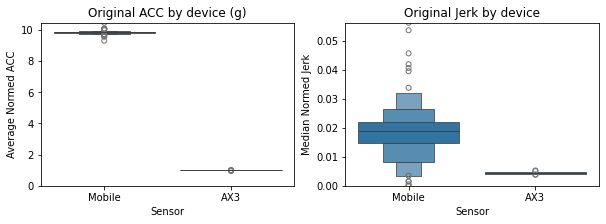

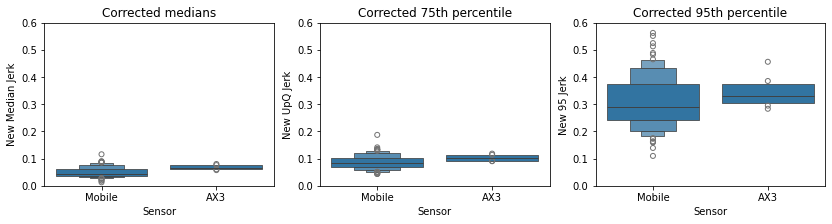

In [86]:
f, (axes) = plt.subplots(1,2,figsize=(10,3))
i = 0
for tag in ['Average Normed ACC','Median Normed Jerk 50Hz']:
    sns.boxenplot(x = 'Sensor',y = tag,data = samples_df, ax = axes[i])
    axes[i].set_ylim([0,samples_df[tag].max()])
    i+=1
axes[0].set_title('Original ACC by device (g)')
axes[1].set_title('Original Jerk by device')

plt.show()    
f, (axes) = plt.subplots(1,3,figsize=(14,3))
i = 0
for tag in ['New Median Jerk','New UpQ Jerk','New 95 Jerk']:
    sns.boxenplot(x = 'Sensor',y = tag,data = samples_df, ax = axes[i])
    axes[i].set_ylim([0,0.6])
    i+=1
    
axes[0].set_title('Corrected medians')
axes[1].set_title('Corrected 75th percentile')
axes[2].set_title('Corrected 95th percentile')

plt.show()    

These distributions show how the smaller correction on the ACC units gives these measurements a chance to land within the range of values captured on the mobile phones. 

Note it is also worth noting that different mobile phone operating systems save accelerometer sensor measurements a bit different. While both record measurements in m/s^2, yeidling average ACC values of gravity at 9.8 (see the distribution in the top plot above), they record with different degrees of precision. iPhones truncating measurements to 5 or 6 digits, while android saves with higher precision (numerical), without any reason to think these values are actually more precise (physical). 

In [87]:
# concert times 10 Hz. This is the sample rate later analyses were performed (surprise!)
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')
binlist = np.concatenate((np.arange(0,1000,200),np.arange(1000,10000, 1000),np.array([50000,1000000])),axis=0)
 # milliseconds

In [88]:
samples_df=pd.DataFrame(index = alignedParts['Participant_Code'],columns = ['Sensor','Average Sample rate','Median sample period','Missing Samples','Average Normed ACC','Median Normed Jerk','New Median Jerk']+list(binlist[1:]))
tic = time.time()

# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000
trial_dic = {}
bad_gaps = []
for i, participant in alignedParts.iterrows(): # .loc[21:21,:]
    part = participant['Participant_Code']
    print(part)
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
        samples_df.loc[part,'Sensor'] = 'Mobile'
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
        samples_df.loc[part,'Sensor'] = 'AX3'
    samples_df.loc[part,'Average Sample period'] = inst_d['device_timestamps'].diff().mean()/1000 #len(inst_d)/((inst_d.time.iloc[-1]-inst_d.time.iloc[0])/1000)
    samples_df.loc[part,'Median sample period'] = inst_d['device_timestamps'].diff().median()/1000
    samples_df.loc[part,'Average Normed ACC'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).median()
    samples_df.loc[part,'Median Normed Jerk'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).diff().abs().median()
    samples_df.loc[part,'UpQ Normed ACC'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).quantile(0.75)
    samples_df.loc[part,'UpQ Normed Jerk'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).diff().abs().quantile(0.75)
    samples_df.loc[part,'95 Normed ACC'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).quantile(0.95)
    samples_df.loc[part,'95 Normed Jerk'] = (inst_d['x'].pow(2) + inst_d['y'].pow(2) + inst_d['z'].pow(2)).pow(0.5).diff().abs().quantile(0.95)
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = am.gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
#         aud_df.loc[:,part] = b*6 # could go down to 5, based on distributions (high end)
        trial_dic[part] = pd.Series(index=dt_ct,data=b*5)
    else:
#         aud_df.loc[:,part] = b
        trial_dic[part] = pd.Series(index=dt_ct,data=b)
    hist, edges = np.histogram(inst_d['device_timestamps'].diff(),bins=binlist,density=False)
    samples_df.loc[part,list(binlist[1:])] = hist
print(time.time()-tic)   
aud_df = pd.concat(trial_dic,axis=1)
print(time.time()-tic)
aud_df.index = dt_ct
samples_df.loc[:,'New Median Jerk'] = aud_df.median()
samples_df.loc[:,'New UpQ Jerk'] = aud_df.quantile(0.75)
samples_df.loc[:,'New 95 Jerk'] = aud_df.quantile(0.95)

ADQ001
ADQ002
ADQ003
ADQ004
ADQ005
ADQ006
ADQ007
ADQ008
ADQ009
ADQ010
ADQ011
ADQ012
ADQ013
ADQ014
ADQ015
ADQ016
ADQ017
ADQ018
ADQ019
ADQ020
ADQ021
ADQ022
ADQ023


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x

ADQ024
ADQ025
ADQ026
ADQ027
ADQ028
ADQ029
ADQ030
ADQ031
ADQ032
ADQ033
ADQ034
ADQ035
ADQ036
ADQ037
ADQ038
ADQ039
ADQ040
ADQ041
ADQ042
ADQ043
ADQ044
ADQ045
ADQ046
ADQ047
ADQ048
ADQ049
ADQ050
ADQ051
ADQ052
ADQ053
ADQ054
ADQ055
ADQ056
ADQ057
ADQ058
ADQ059
ADQ060
ADQ061
ADQ062
ADQ063
ADQ064
ADQ065
ADQ066
ADR067
ADR068
ADR069
ADR070
ADR071
AEQ077
AEQ078
AEQ079
AEQ080
AEQ081
AEQ082
AEQ083
AEQ084
AEQ085
AEQ086
AEQ087
AEQ088
AEQ089
AER090
BDQ092
BDQ093
BEQ095
BEQ096
BEQ097
BEQ098
BEQ099
BEQ100
BEQ101
BEQ102
BEQ103
BEQ104
BEQ105
BEQ106
BEQ107
BEQ108
BEQ109
BEQ110
BEQ111
BEQ112
BEQ113
BEQ114
BEQ115
BEQ116
BEQ117
BEQ118
BEQ119
BnQ131
BnQ132
BnQ133
157.5197718143463
157.6132936477661


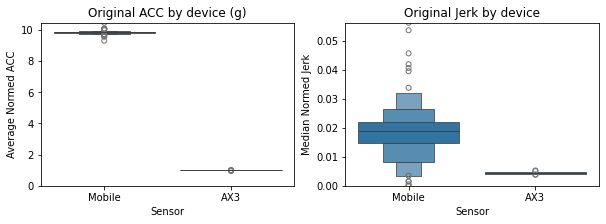

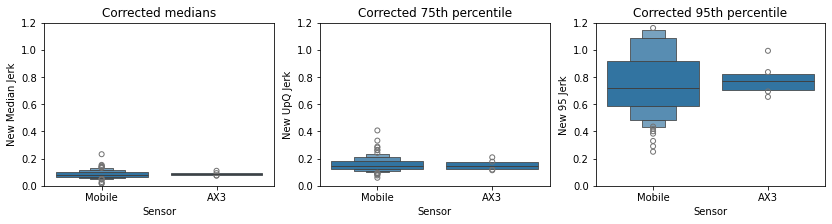

In [94]:
f, (axes) = plt.subplots(1,2,figsize=(10,3))
i = 0
for tag in ['Average Normed ACC','Median Normed Jerk']:
    sns.boxenplot(x = 'Sensor',y = tag,data = samples_df, ax = axes[i])
    axes[i].set_ylim([0,samples_df[tag].max()])
    i+=1
axes[0].set_title('Original ACC by device (g)')
axes[1].set_title('Original Jerk by device')

plt.show()    
f, (axes) = plt.subplots(1,3,figsize=(14,3))
i = 0
for tag in ['New Median Jerk','New UpQ Jerk','New 95 Jerk']:
    sns.boxenplot(x = 'Sensor',y = tag,data = samples_df, ax = axes[i])
    axes[i].set_ylim([0,1.2])
    i+=1
    
axes[0].set_title('Corrected medians')
axes[1].set_title('Corrected 75th percentile')
axes[2].set_title('Corrected 95th percentile')

plt.show()    

The range of values measured on mobile is broader (unimodal) than the AX3 but this correction for AX3s allows the upper range of values (when motion is occuring) to fall within the same spread. Correcting to the same accelation measurements (1 g to 9.8 m/s^2) would dramatically over shoot the measurements distributions. Because the weight of the sensor system is so different from phones, more comparable values are captured with this empirically-evaluated coefficient adjustment.

There are some questions about the differences between mobile devices: here we can't perform a systematic correction, but at least the average ACC measurements show that these devices consistently record in g's. The principle difference in operating systems (iOS and Adnroid) is in the precision recorded, specifically the number of digits. These however are not relevant for these analyses because we are not preserving the original sensor values, as everything is resampled, and both systems are sufficiently precise to not introduce systematic deviations into our use of the values recorded. 

Other uses of these measurements might be bothered by the differences, but here our treatments are not so sensitive